In [1]:
import argparse
import random

import numpy as np
import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds


/home/dell/anaconda3/envs/time/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dell/anaconda3/envs/time/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dell/anaconda3/envs/time/lib/python3.8/site-packages/umap/distances.py:108

In [2]:
torch.cuda.is_available()
# torch.cuda.device_count()
# torch.cuda.current_device()

True

In [3]:
print(torch.__version__)
print(torch.version.cuda)

1.12.1
11.3


In [4]:
import scvelo as scv
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix

In [5]:
data_path='data/'
result_path='result/'
adata0=scv.read(data_path+'DG_bin.h5ad', cache=True)

In [6]:
adata0

AnnData object with n_obs × n_vars = 3184 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'ClusterName_colors', 'neighbors', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unsplic

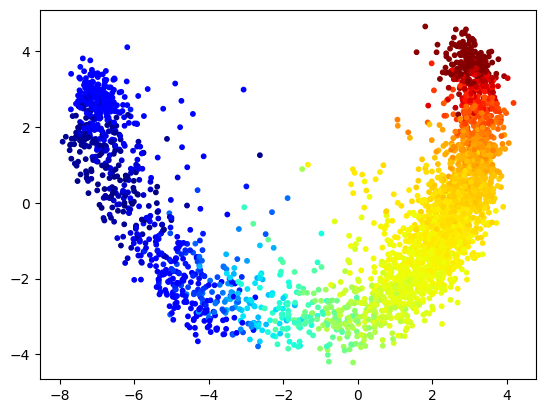

In [7]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=adata0.obs['velocity_pseudotime'].values,cmap=plt.cm.jet)
plt.show()

# plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=adata0.layers['variance_velocity'],cmap=plt.cm.jet)
# plt.show()

In [8]:
#-------data preprocessing
k_nei=10
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()

col=adata.uns['neighbors']['indices'].flatten()

adj_val=np.ones(col.shape)

A_mat=csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [10]:
X0_ori=adata0.layers['Ms']#adata.X.A#
scaler=MinMaxScaler(feature_range=(0,1))#StandardScaler()#
X=scaler.fit_transform(X0_ori)

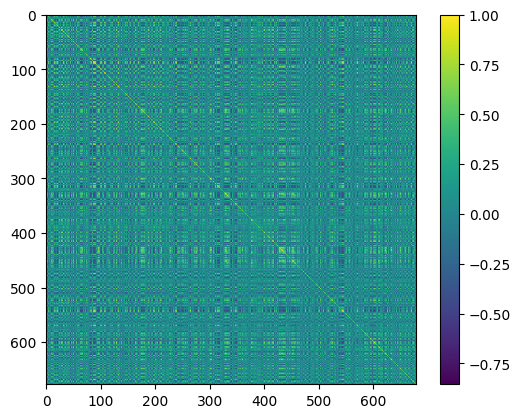

In [11]:

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

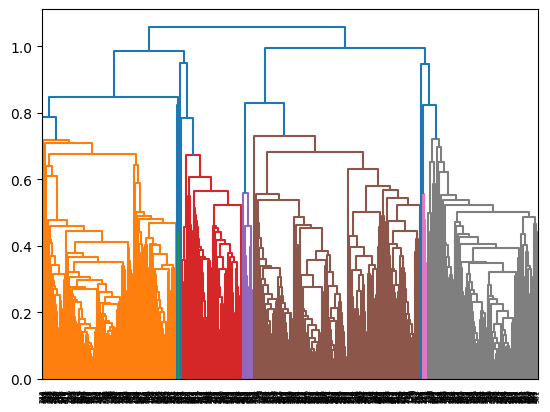

In [12]:
Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

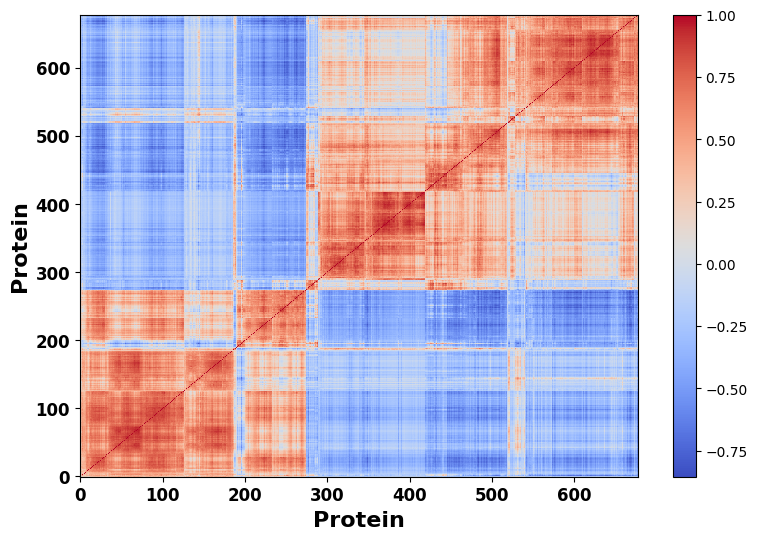

In [13]:
X_corr_re=np.corrcoef(X_re, rowvar=False)

plt.figure(figsize=(9,6))
plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')

plt.xlabel('Protein',fontsize=16,fontweight='bold')
plt.ylabel('Protein',fontsize=16,fontweight='bold')

plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.colorbar()
# plt.savefig('heatmap_order.png',dpi=300)
plt.show()

In [14]:
epochs = 200
nsamples = 5
learning_rate = 1e-3
seed = 0
n_workers = 4
K =3# !!!!!!!!!! K should be large enough
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

if seed is not None:
    reset_seeds(seed)

A=A_mat
X=X0_ori
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=adata0.obs['velocity_pseudotime'].values

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = 3
encoder = Encoder(X.shape[1], L)

In [15]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs // n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [16]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(7.1993e+09, grad_fn=<DivBackward0>)
10 tensor(2.8277e+09, grad_fn=<DivBackward0>)
20 tensor(2.7306e+09, grad_fn=<DivBackward0>)
30 tensor(2.7109e+09, grad_fn=<DivBackward0>)
40 tensor(2.6734e+09, grad_fn=<DivBackward0>)
50 tensor(2.7172e+09, grad_fn=<DivBackward0>)
60 tensor(2.6567e+09, grad_fn=<DivBackward0>)
70 tensor(2.6440e+09, grad_fn=<DivBackward0>)
80 tensor(2.6538e+09, grad_fn=<DivBackward0>)
90 tensor(2.6339e+09, grad_fn=<DivBackward0>)
100 tensor(2.6173e+09, grad_fn=<DivBackward0>)
110 tensor(2.6432e+09, grad_fn=<DivBackward0>)
120 tensor(2.6663e+09, grad_fn=<DivBackward0>)
130 tensor(2.6314e+09, grad_fn=<DivBackward0>)
140 tensor(2.6511e+09, grad_fn=<DivBackward0>)
150 tensor(2.6482e+09, grad_fn=<DivBackward0>)
160 tensor(2.6481e+09, grad_fn=<DivBackward0>)
170 tensor(2.6125e+09, grad_fn=<DivBackward0>)
180 tensor(2.6150e+09, grad_fn=<DivBackward0>)
190 tensor(2.6552e+09, grad_fn=<DivBackward0>)


In [17]:
z=train_data.z
mu, sigma = encoder(train_data.X)
mu_learned = mu.detach().numpy()
sigma_learned = np.sqrt(sigma.detach().numpy())

In [18]:
sort_idx = z.argsort()

match_idx=sort_idx[np.searchsorted(z,adata0.obs['velocity_pseudotime'].values,sorter = sort_idx)]
print(match_idx)

[2881 2374 1838 ...  695 1556 1497]


In [19]:
X_mu=mu_learned[match_idx]
X_sigma=sigma_learned[match_idx]
X_label=z[match_idx]

In [20]:
# latent_z=[]
# for i in range(X_mu.shape[1]):
#     latent_z.append(X_mu[:,i])
#     latent_z.append(X_sigma[:,i])
# latent_z=np.array(latent_z).T
latent_z=np.hstack((X_mu,X_sigma))

latent_z.shape

(3184, 6)

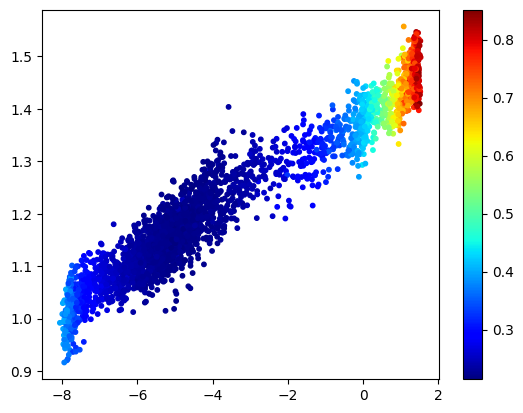

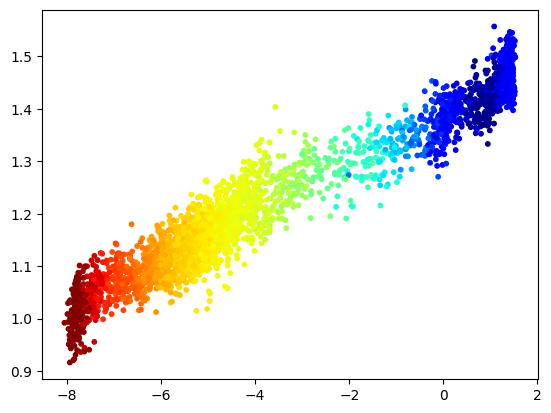

In [21]:
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(1/X_sigma**2,axis=1),cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=X_label,cmap=plt.cm.jet)
plt.show()

In [22]:
Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,2*j,2*j]=1/(X_sigma[i,0]**2)
        Fisher_g[i,2*j+1,2*j+1]=2/(X_sigma[i,0]**2)

In [23]:
# for j in range(L*2):

#     plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=Fisher_g[:,j,j],cmap=plt.cm.jet)
#     plt.colorbar()
#     plt.show()

In [24]:
def Fisher_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

In [25]:
def KL_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    KL_dist=0
    for i in range(dim):
        #the after KL_12+KL_21 the log(det(sigma1)/det(sigma2))+log(det(sigma2)/det(sigma1))=0
        # so do not calculate this term
        KL_12=1/2*(-1+sigma1[i]**2/sigma2[i]**2+dmu[i]**2/sigma2[i]**2)
        KL_21=1/2*(-1+sigma2[i]**2/sigma1[i]**2+dmu[i]**2/sigma1[i]**2)
        KL_sym=KL_12+KL_21
        KL_dist+=KL_sym
    return KL_dist

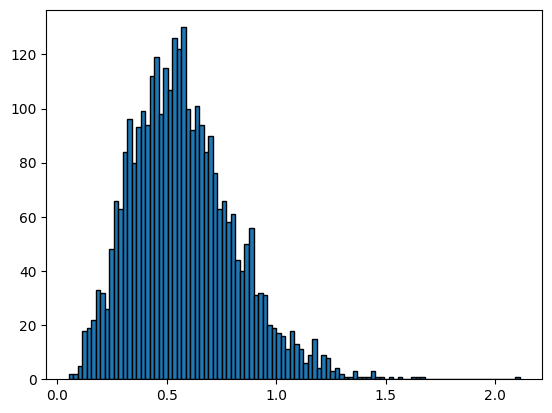

In [26]:
#-------------calcualte distance pair--------------
dist_ratios=[]
for inds in np.split(A.indices, A.indptr)[1:-1]:

    dist_r=[]
    self_ind=inds[0]
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])

        gau_dEu=np.linalg.norm(X_mu[self_ind,:]-X_mu[inds[nei_k],:])
        
        dKL=KL_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        dist_r.append(dEu/dFi)

        
        
#     print(np.std(dist_r)/np.mean(dist_r))
    
    dist_ratios.append(np.std(dist_r)/np.mean(dist_r))

plt.hist(np.array(dist_ratios),bins=100,edgecolor='black')
plt.show()

In [27]:
def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

In [28]:
cRc_arr=[]
for inds in np.split(A.indices, A.indptr)[1:-1]:

    self_ind=inds[0]
    cRc=0
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        dWa=wasserstein_distance(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        cRc+=(1-dWa/dEu)
    
    cRc_arr.append(cRc/len(inds))
#     cRc_arr.append(cRc)

In [29]:
# scv.pl.scatter(adata=adata0, basis='pca',c='ClusterName')

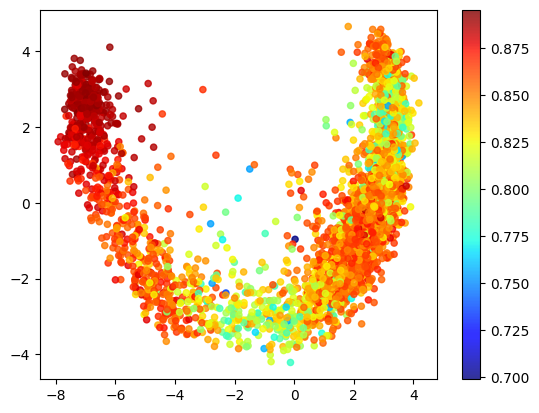

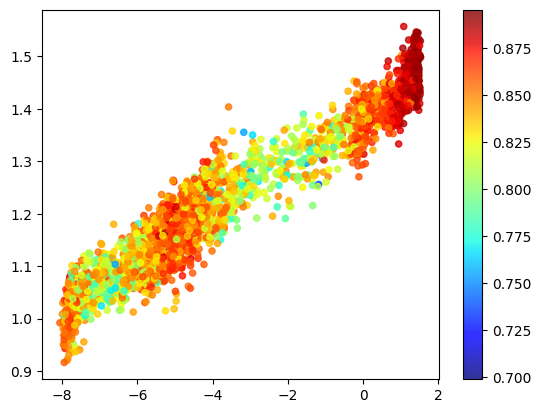

In [30]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(X_mu[:,0],X_mu[:,1], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

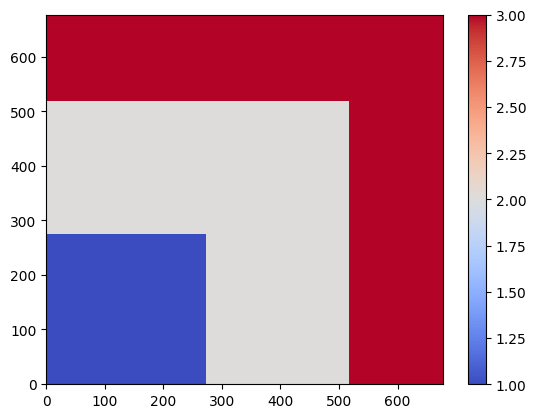

In [31]:
td=0.99
T=fcluster(Z, t=td, criterion='distance')

T_re=T[dg['leaves']]

X_corr_label=X_corr_re.copy()
for i in range(X_corr_re.shape[0]):
    X_corr_label[:,i]=T_re[i]
    X_corr_label[i,:]=T_re[i]

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()



In [32]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w=[]
    for i in np.unique(T_re):
        pca=PCA(n_components=0.98).fit(X_re[:,T_re==i])
#         print(pca.explained_variance_ratio_)
        pc1=pca.transform(X_re[:,T_re==i])[:,0]
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return eigen_X_w

In [33]:

eigen_X_w=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))


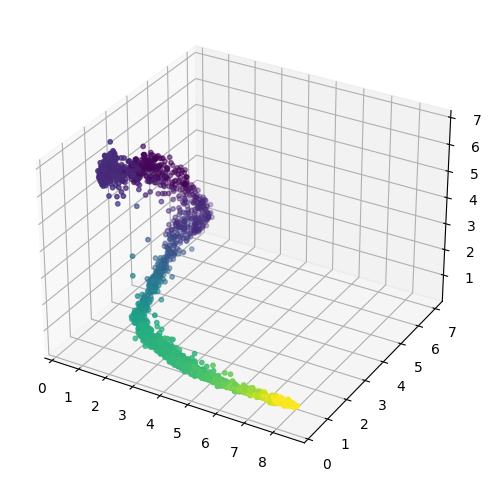

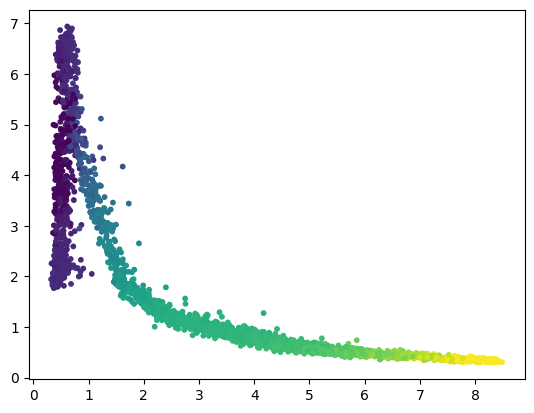

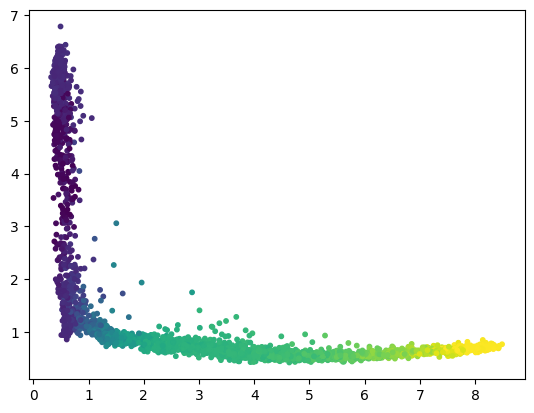

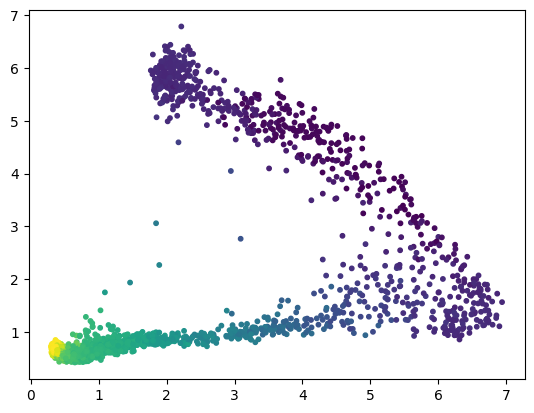

In [34]:
#---------eigen gene of each single cell----------------
cell_eigen_X=np.zeros((X_re.shape[0],eigen_dim))
for j in range(X_re.shape[0]):
    for k in range(len(eigen_X_w)):
        cell_eigen_X[j,k]=np.dot(eigen_X_w[k],X_re[j,T_re==k+1])

#plot eigen gene 
fig= plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cell_eigen_X[:,0],cell_eigen_X[:,1],cell_eigen_X[:,2],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

plt.scatter(cell_eigen_X[:,0],cell_eigen_X[:,1],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

plt.scatter(cell_eigen_X[:,0],cell_eigen_X[:,2],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

plt.scatter(cell_eigen_X[:,1],cell_eigen_X[:,2],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

In [35]:
vec_F=SparseVFC(cell_eigen_X,latent_z,Grid=cell_eigen_X)
#partial derivtive of Mu of each Gmm component with repect to each eigen gene
pMu_pEg=Jacobian_rkhs_gaussian(cell_eigen_X, vec_F)
pMu_pEg=np.transpose(np.array(pMu_pEg),[2,0,1])

In [36]:
pMu_pEg.shape

(3184, 6, 3)

In [37]:

eigen_gij=np.zeros((X.shape[0],eigen_dim,eigen_dim))


for l in range(X.shape[0]):
#     loc_sample=[]
#     for s in range(n_sample):
#         loca_sample.append(multivariate_normal.rvs(mean=X_learned[l,:],cov=Y_learned[l,:]))


    for p in range(eigen_dim):
        for q in range(eigen_dim):
            for gi in range(L):
                eigen_gij[l,p,q]+=(1/latent_z[l,L+gi]**2)*pMu_pEg[l,gi,p]*pMu_pEg[l,gi,q]+\
                                  (2/latent_z[l,L+gi]**2)*pMu_pEg[l,gi+L,p]*pMu_pEg[l,gi+L,q]
 

In [38]:
eigen_gij.shape

(3184, 3, 3)

In [39]:
velo = np.array(adata0.layers['velocity'])
velo_re= velo[:,dg['leaves']]

In [40]:
velo_eigen=np.zeros([X.shape[0], eigen_dim])
for i in range(X.shape[0]):
    for k in range(len(eigen_X_w)):
        velo_eigen[i,k]=np.dot(eigen_X_w[k],velo_re[i,T_re==k+1])

In [41]:
z_velo=[]
zv2 = np.array([velo_eigen[l]@eigen_gij[l]@velo_eigen[l] for l in range(eigen_gij.shape[0])])
zv1 = np.sqrt(zv2)
    

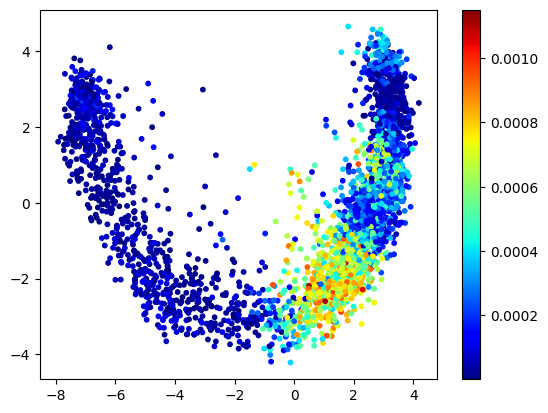

In [42]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=zv1,cmap=plt.cm.jet)
plt.colorbar()
plt.show()


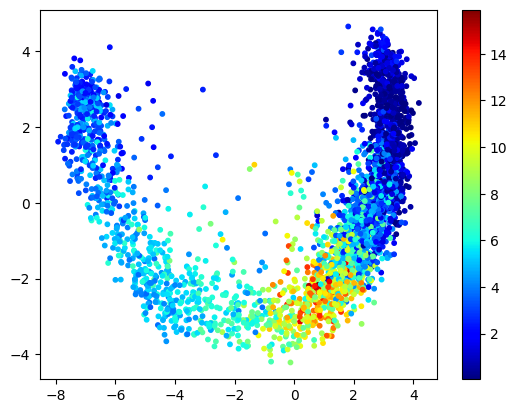

In [43]:
eigen_v_norm = np.array([np.dot(velo_eigen[l],velo_eigen[l]) for l in range(eigen_gij.shape[0])])
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=eigen_v_norm,cmap=plt.cm.jet)
plt.colorbar()
plt.show()


In [44]:
#---------------fisher info on pca


In [45]:

pca_dim=15
X_pca=adata.obsm['X_pca'][:,:pca_dim]
velo_pca=adata.obsm['velocity_pca'][:,:pca_dim]
vec_F=SparseVFC(X_pca,latent_z,Grid=X_pca)
#partial derivtive of Mu of each Gmm component with repect to each eigen gene
pMu_pEg=Jacobian_rkhs_gaussian(X_pca, vec_F)
pMu_pEg=np.transpose(np.array(pMu_pEg),[2,0,1])

In [46]:
pMu_pEg.shape

(3184, 6, 15)

In [47]:
pca_dim=X_pca.shape[1]
pca_gij=np.zeros((X.shape[0],pca_dim,pca_dim))


for l in range(X.shape[0]):
#     loc_sample=[]
#     for s in range(n_sample):
#         loca_sample.append(multivariate_normal.rvs(mean=X_learned[l,:],cov=Y_learned[l,:]))


    for p in range(pca_dim):
        for q in range(pca_dim):
            for gi in range(L):
                pca_gij[l,p,q]+=(1/latent_z[l,L+gi]**2)*pMu_pEg[l,gi,p]*pMu_pEg[l,gi,q]+\
                                  (2/latent_z[l,L+gi]**2)*pMu_pEg[l,gi+L,p]*pMu_pEg[l,gi+L,q]
            
            
#             pca_gij[l,p,q]=(1/latent_z[l,1]**2)*pMu_pEg[l,0,p]*pMu_pEg[l,0,q]+\
#                             (1/latent_z[l,3]**2)*pMu_pEg[l,2,p]*pMu_pEg[l,2,q]+\
#                             (2/latent_z[l,1]**2)*pMu_pEg[l,1,p]*pMu_pEg[l,1,q]+\
#                             (2/latent_z[l,3]**2)*pMu_pEg[l,3,p]*pMu_pEg[l,3,q]

In [48]:
z_velo=[]
zv2 = np.array([velo_pca[l]@pca_gij[l]@velo_pca[l] for l in range(pca_gij.shape[0])])
zv1 = np.sqrt(zv2)

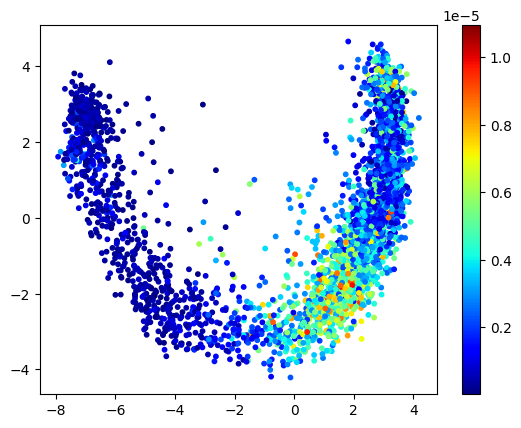

In [49]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=zv1,cmap=plt.cm.jet)
plt.colorbar()
plt.show()


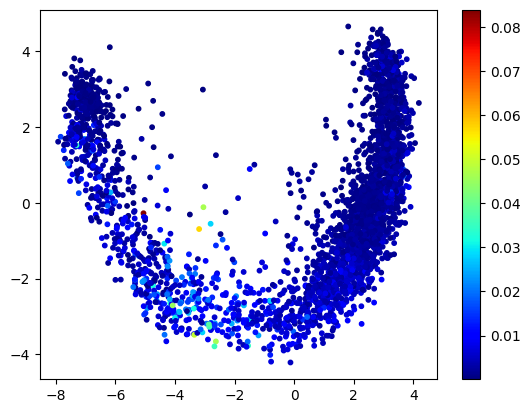

In [50]:
pca_v_norm = np.array([np.dot(velo_pca[l],velo_pca[l]) for l in range(pca_gij.shape[0])])
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=pca_v_norm,cmap=plt.cm.jet)
plt.colorbar()
plt.show()
